
# Color Analysis of Bandcamp Album Cover Art
## Coen D. Needell


## Introduction

The internet has allowed any artist to share their work with the world, and in many cases be paid for it. This is mostly a recent development, with the creation of online marketplaces, and patronage services. The defining marketplace for the indie music scene on the internet is [Bandcamp](https://www.bandcamp.com). Although it has been difficult to find an estimate for how large this marketplace actually is, Bandcamp does report some information about how much money has been spent on their platform. According to their home page:
> Fans have paid artists \$468 million using Bandcamp, and \$9.5 million in the last 30 days alone.

According to Google, there are ~20 million indexed sites under the bandcamp domain. This seems to correspond roughly with the number of artists on the marketplace. These artists are spread across 10 "genres" but they're allowed to attach their own genre tags to their music. This investigation will look at how colors are used to signal these genre and subgenre tags. For the purposes of this discussion, we will not distinguish between "genre" and "subgenre," and will instead use the term "tag" to describe groups of albums. We will look at how indie musicians on Bandcamp use color choices in their album covers to signal their tags. Using tools usually developed for natural language processing, we'll be able to take these album covers, decomposed into their most prominent colors, and then extract "topics" from those sets. The topics are generated through Latent Dirichlet Allocation, which extracts features from text ang generates topics, based on words that appear together. In our case, we will adapt that process to work for colors. The topics are generated in an unsupervised manner, and displays the topic as a set of colors, leaving interpretation up to a human, but no matter what we name these color-topics, we will still be able to see how individual album covers are composed out of those color-topics. 

## Analysis 

Being that this discussion centers around examining a cultural pattern, it's important to have an explicit idea of what we mean by "culture". For the purposes of this discussion, we'll use a very simple definition of the word. Culture in this context is the set of conventions for producing signs that are common to people within a group. In our case, those conventions are the common features and qualia of album covers, and the groups are the artists and fans that listen to music within a tag. We will also be considering this phenomenon within a specific framework for the metaphysics of signs (semiotics) put forth by Charles Sanders Peirce. Within this framework, a sign is a creature of three parts: the sign-vehicle, the information-carrying thing; the object, the thing about which the sign communicates; and the interpretant, the message being signified by the sign. In our case, we are trying to isolate sign-vehicles and interpretants, where the object of these signs is firmly the music. The interpretants form statements along the lines of "this music is has a certain quality". In the Peircian framework, we call this a "dicent". Ideally, the color-topics that we uncover will be 'iconic', because they ought to resemble the quality that they're trying to show, but in many cases, they will be 'indexical'([@Peirce_1955]). Color-topics formed of skin-tones, and grayscales cannot be interpreted without knowing the context, so these topics must be associated with an index, the image of the album, as well as the music itself. In some cases, such as within hip-hop, grayscale can be used to impute seriousness, but in other cases, like with alternative rock, grayscale images are used to signify melancholy. Color-topics like these must be interpreted in association with their music, and lose meaning when isolated from their tags.

As we go through this discussion, I'm making my analysis as an offshoot of Benstock and Ferriss' theory of fashion([@Benstock_Ferriss_1994]), in that it's a semi-structured, visual way for a person to show their allegiances of a sort. While in their case, it was cultural groups, as well as a concept of high-fashion and low-fashion, we're going to dispense with the value-aspect of things and just focus on group-affiliation, which in our case is the tags. This analysis is also loosely based off of technology developed by Dorochowicz and Kostek ([@Dorochowicz_Kostek_2019]). Their core idea is to take design concepts and look at how they're used in mainstream music markets, i.e. markets where the goal of a work is more to sell rather than to inform. 

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import colorgram
import bc_tools as bw
import pickle
import os
from tqdm import tqdm
from collections import defaultdict
np.random.seed(10101)

First thing's first, let's load the data up. Currently the data is being stored in `colorgrams/*`. The files are organized such that the numbered name of the file is a unique identifier, the hash of the album and artist name. We have just under 65 thousand data points, spanning 9 major tags, from around 21 thousand artists.

In [2]:
data_dict = {}
for dat in tqdm(os.listdir('./colorgrams/')):
    with open(f'./colorgrams/{dat}', 'rb') as f:
        packet = pickle.load(f)
        for key in packet:
            try:
                data_dict[key].append(packet[key])
            except KeyError:
                data_dict[key] = [packet[key]]

df = pd.DataFrame(data_dict)
df.head()

100%|██████████| 64556/64556 [00:09<00:00, 6560.52it/s]


,title,artist,tags,album,url,store,colorgram
0,Gentrification III: Death and Displacement,Street Sects,"[electronic, industrial metal, metal, noise, p...",gentrification-iii-death-and-displacement,https://streetsects.bandcamp.com/album/gentrif...,streetsects,"[(253, 253, 253), (5, 5, 5), (94, 94, 94), (16..."
1,Looking For Today,The Rare Breed,"[rock, classic rock, doom, grunge, hard rock, ...",looking-for-today,https://ripplemusic.bandcamp.com/album/looking...,ripplemusic,"[(2, 1, 1), (111, 81, 113), (43, 25, 51), (166..."
2,Lucky Strikes (Free Drumbreak),J-Zone,"[funk, drum breaks, funk, hip-hop, instrumenta...",lucky-strikes-free-drumbreak,https://j-zone.bandcamp.com/track/lucky-strike...,j-zone,"[(252, 248, 241), (218, 72, 47), (1, 0, 0), (1..."
3,Drum Loops Volume 1,The Polish Ambassador,"[experimental, beat packs, breakbeat, david su...",drum-loops-volume-1,https://thepolishambassador.bandcamp.com/album...,thepolishambassador,"[(246, 229, 155), (9, 34, 46), (55, 115, 85), ..."
4,Destination Infinite,MindSpring Memories,"[80s, 90s, diy, electronic, experimental, avan...",destination-infinite,https://swampcircle.bandcamp.com/album/destina...,swampcircle,"[(251, 224, 243), (246, 246, 196), (101, 240, ..."


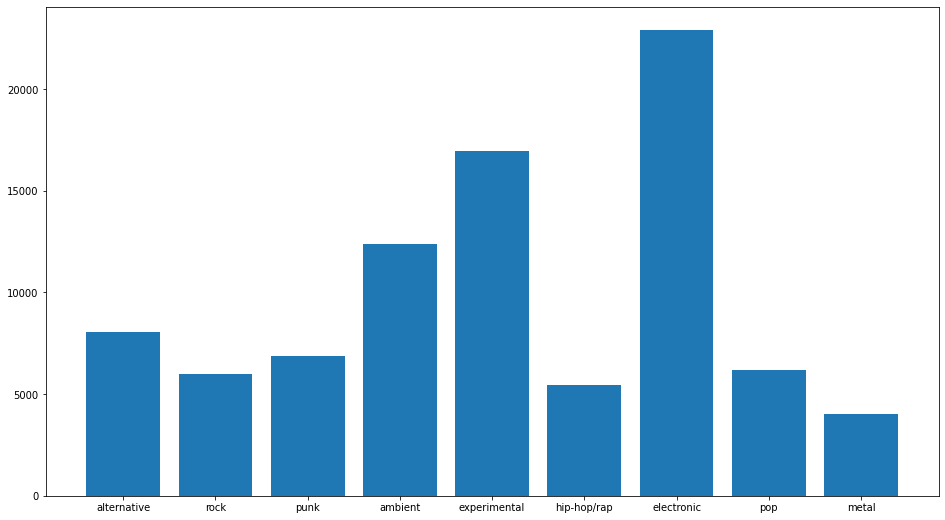

In [3]:
major_tags = {'hip-hop/rap', 'electronic', 'ambient', 'punk', 'pop', 'rock', 'alternative', 'metal', 'experimental'}
maj_tag_counts = defaultdict()
for tag in major_tags:
    maj_tag_counts[tag] = np.sum(df['tags'].apply(lambda x: tag in x))
plt.figure(figsize = (16, 9))
plt.bar(range(len(maj_tag_counts)), list(maj_tag_counts.values()))
plt.xticks(range(len(maj_tag_counts)), maj_tag_counts.keys())
plt.show()

The above plot shows the distribution of our dataset across the major tags (as defined by Bandcamp itself.) We see a dominant show from "experimental", "electronic", and "ambient". There's sure to be some crossover between electronic and ambient, and Bandcamp was originally popularized by the electronic scene. As for "experimental," well, who doesn't call themselves experimental?

Now we need to downscale the colorgrams to a lower bit-depth. The analysis that we're doing involves constructing a lexicon of colors, and at the current bit depth, (8-bit per color channel), that lexicon consists of 17 million colors. We'll cut that down to about 4 thousand by reducing it to 4-bits per color channel. We'll just round each color to the closest color on the 12-bit color pallette. 

In [4]:
df['colorgram12'] = df['colorgram'].apply(bw.rgb_color_converter, args=(8, 4))
all_colors = df['colorgram12'].values
all_colors = [col for cg in all_colors for col in cg]
print(f'There are {len(np.unique(all_colors, axis=0))} unique colors in the lexicon.')

There are 4052 unique colors in the lexicon.


Now we need to convert each colorgram to a document, so that it can be handled by a text-representation method.

In [5]:
df['cg_text'] = df['colorgram12'].apply(bw.cg2doc)

Now for the topic modeling. We're using a Tf-idf method to vectorize the data, this decomposes each colorgram into a vector, it works by decomposing the colorgram into individual colors, then counting the occurances of each color, and then normalizing those counts and weighting them based on commonality. More common colors are weighted lower. Then we're using Latent Dirichlet Allocation to decompose each document into general topics. We're creating 18 separate topics, you can see where that number came from in the previous, preliminary analysis [here](https://www.coeneedell.com/post/bandcamp_prelims/).

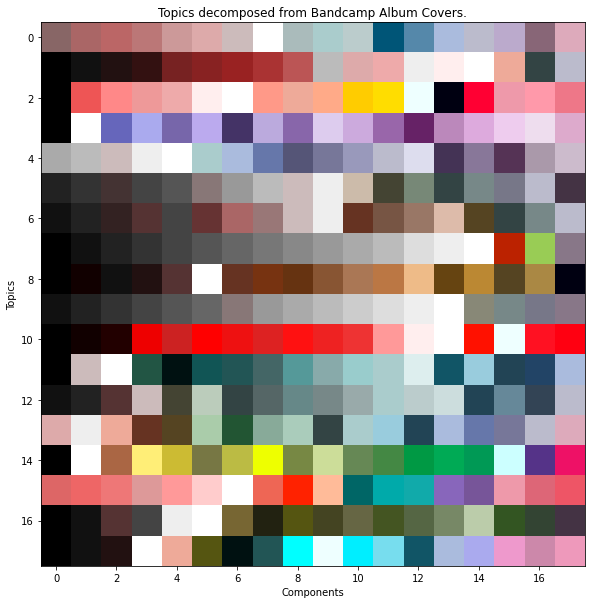

In [6]:
lda = Pipeline([
    ('c_vec', TfidfVectorizer()),
    ('lda', LatentDirichletAllocation(n_components=18, n_jobs=-1))
])

lda.fit_transform(df['cg_text'])
plt.figure(figsize=(10, 10))
plt.imshow(bw.get_topics(lda, n_feats=18))
plt.title('Topics decomposed from Bandcamp Album Covers.')
plt.xlabel('Components')
plt.ylabel('Topics')
plt.show()

This decomposes quite nicely. We can easily identify sets of Earth Tones(16), Sea Tones(11-12), Skin Tones(8), and Florals(3-4). 


In [14]:
decomp = lda.transform(df['cg_text'])
df['dominant_topics'] = np.argmax(decomp, axis=1)

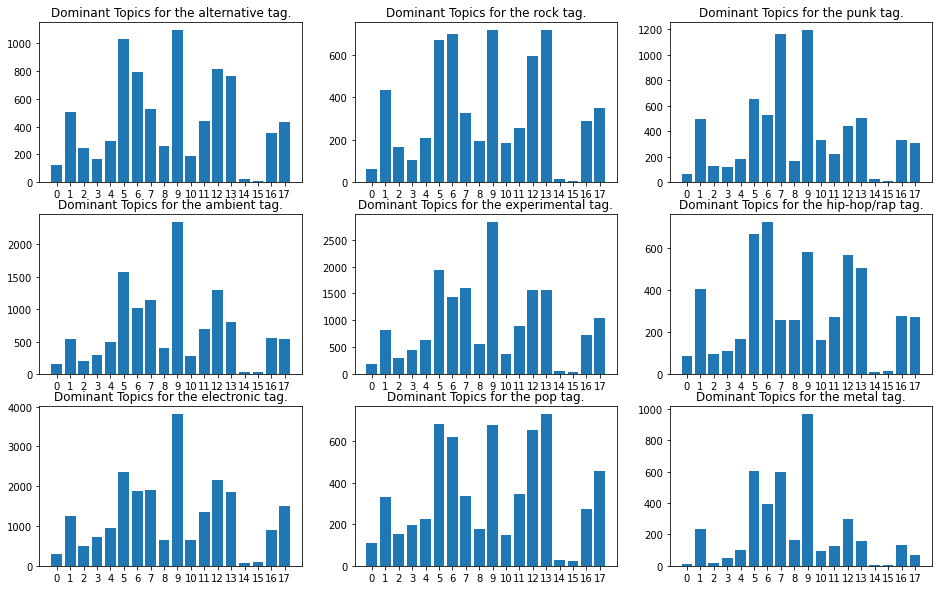

In [42]:
fig, axs = plt.subplots(3, 3, figsize=(16, 10))
top_topic_counts_by_tag = {}

for tag, ax in zip(major_tags, axs.flat):
    vals = df['dominant_topics'].loc[[tag in t for t in df['tags']]]
    top_topic_counts_by_tag[tag] = np.unique(vals, return_counts=True)
    ax.bar(*top_topic_counts_by_tag[tag])
    ax.set_title(f'Dominant Topics for the {tag} tag.')
    ax.set_xticks(range(18))

The first thing we notice is that every major tag has a large number of albums that use grayscale as their dominant color-topic. Barring pop and hip-hop/rap, topic # 9 is the most common dominant color-topic in every major tag. We see that some color-topics are just more common in general. Remember that this particular plot only shows us how many albums have each color-topic as their most dominant topic, so from it alone, we can't make any inferences about mixtures of topics. We can, however, see that some topics are uniquely focused on by some tags. Topic # 7 is popular among many tags but is uniquely dominant in punk. Topic # 7 is constructed out of gray-scale, with pops of color, primarily a dark red and a neon green. A possible interpretation for this is that this topic represents the use of contrast. The punk-music scene has as a common theme the idea of standing out, uniqueness. It stands to reason that this topic is being used to signify that sense of societal isolation. Another feature like this is in pop, rock, and hip-hop/rap tags. These tags are generally thought of as the "mainstream" tags, these tags share a feature; all three have a large number of albums dominated by topics 12 and 13, topics I would term as sea tones and forest tones. These colors are generally associated with natural scenes, associating the artist with the Earth and nature. Topic # 6 also sees heavier use in these tags, this is the skin-tone topic. This implies that a lot of artists in these tags will use people, most likely themselves, in their album covers. This can emphasize to the listener that this music is an embodiment of the artist's self. 

Let's take a closer look at the electronic tag, the most popular tag in our dataset.

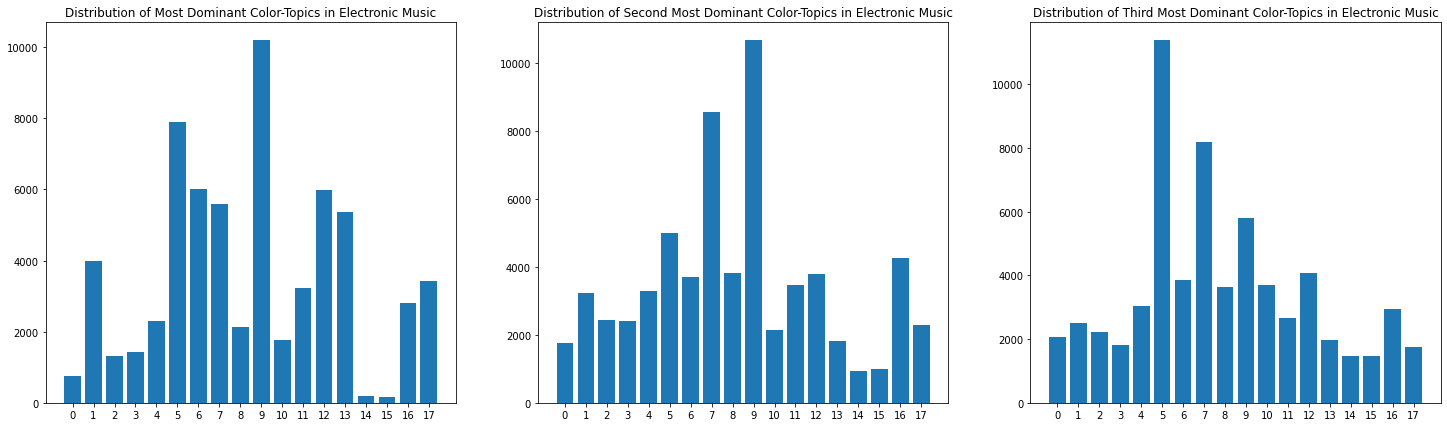

In [93]:
electronic = df.loc[['electronic' in t for t in df['tags']]]
elec_decomp = decomp[['electronic' in t for t in df['tags']]]
electronic_top_3s = np.argsort(decomp, axis=1)[:, -3:][:, ::-1]
electronic_top_3s_val = np.sort(decomp, axis=1)[:, -3:][:, ::-1]
crop_loss = 1 - np.sum(electronic_top_3s_val, axis=1)
elec_r1 = np.unique(electronic_top_3s[:, 0], return_counts=True)
elec_r2 = np.unique(electronic_top_3s[:, 1], return_counts=True)
elec_r3 = np.unique(electronic_top_3s[:, 2], return_counts=True)

fig, axs = plt.subplots(1, 3, figsize = (25, 7))
axs = axs.flat
axs[0].bar(*elec_r1)
axs[0].set_xticks(range(18))
axs[0].set_title('Distribution of Most Dominant Color-Topics in Electronic Music')
axs[1].bar(*elec_r2)
axs[1].set_xticks(range(18))
axs[1].set_title('Distribution of Second Most Dominant Color-Topics in Electronic Music')
axs[2].bar(*elec_r3)
axs[2].set_xticks(range(18))
axs[2].set_title('Distribution of Third Most Dominant Color-Topics in Electronic Music')
plt.show()

The first thing that we notice compared with the more generalized plots is the fact that topics 14 and 15 actually appear as secondary and tertiary topics, whereas they're practically never dominant. We see grayscale takes a plunge in popularity after the secondary level. We also see that topic # 7 is very common as a tertiary topic in electronic music. Topic # 7 is the contrast topic that we discussed before in the context of punk music. In this context, the contrast is less the point and more of an accent. Electronic music is often intended to be a vision of the future, and not much invokes those same feelings as brightly colored lights in the darkness. That is probably where this topic is coming in, again, not as the focus of the piece, but still there. We also see that topic number 8, skin tones, is rarely seen in the context of electronic music. In many cases, depicting a human on the album cover for electronica would send the wrong message, so it's omitted. 

In general, we see a lot of evidence to support the theory that the album cover is a digital sign that stands as an advertisement to the potential fan about the character of the music. There is quite a bit of consideration associated with the fact that Bandcamp is ultimately an _alternative_ music platform(Hesmondhalgh 2019). So in many cases, even if a musician's work is characteristically mainstream, they will draw from a concept of alternative-ness simply by their presence on the platform. There is, however, an alternative hypothesis that we should entertain. There is a concern that the color-topics appear not as sign-vehicles themselves, but are secondary to the sign-vehicle formed by depictions in images. It is true, that if the dataset were made up of album covers that use similar iconography, they would, under many cases, decompose into similar color-topics. There are two problems with this alternative hypothesis. In the first set of plots, we can see that topics like 9, 12, and 13 are common dominant topics between even disparate tags like pop and punk. From our prior knowledge about these subcultures, we know that they do not use similar iconography(Libeks 2011). So these similar color-topics must arise from conventions about what those colors mean.

## Concluding Remarks


Bandcamp, in general, is a great digital "petri dish" for studying music culture in the 21st century. Its stance as a bastion away from the mainstream music market allows it to be a place where people make the music that they want to, rather than responding to the market. The creation of color-topics can help us understand this secondary community within the larger music universe. In addition, the methods that I use in this discussion show that the tools we generally use for language processing can be applied to more areas. Understanding how an artist presents themself can help us understand not only the production of music but also the ways that visual signs are associated with a community. Often the tags that are applied to music are used to represent a subculture at large, and as such can be integral to that subculture's identity. Electronica, for example, uses very regimented conventions in its album covers. A quick scan of the top albums on Bandcamp at the time of writing and we see 6 abstract covers, three that contain buildings, 3 that involve bright colors and are mostly text, and another two that depict complex machinery. None of these covers are particularly unique, yet they use these things in concert in different ways. It's clear that some sort of decomposition can help us understand how these ideas are mixed and matched to express the endless spectra of musical tastes. Hopefully, this analysis is a small step toward achieving that. 

## Bibliography
---
Benstock, Shari, and Suzanne Ferriss, eds. On Fashion. New Brunswick, N.J: Rutgers University Press, 1994.

DeWall, C. Nathan, Richard S. Pond, W. Keith Campbell, and Jean M. Twenge. “Tuning in to Psychological Change: Linguistic Markers of Psychological Traits and Emotions over Time in Popular U.S. Song Lyrics.” Psychology of Aesthetics, Creativity, and the Arts 5, no. 3 (August 2011): 200–207. https://doi.org/10.1037/a0023195.


Dorochowicz, Aleksandra, and Bozena Kostek. “Relationship between Album Cover Design and Music Genres.” In 2019 Signal Processing: Algorithms, Architectures, Arrangements, and Applications (SPA), 93–98. Poznan, Poland: IEEE, 2019. https://doi.org/10.23919/SPA.2019.8936738.

Hesmondhalgh, David, Ellis Jones, and Andreas Rauh. “SoundCloud and Bandcamp as Alternative Music Platforms.” Social Media + Society 5, no. 4 (October 2019): 205630511988342. https://doi.org/10.1177/2056305119883429.


Libeks, Janis, and Douglas Turnbull. “You Can Judge an Artist by an Album Cover: Using Images for Music Annotation.” IEEE Multimedia 18, no. 4 (April 2011): 30–37. https://doi.org/10.1109/MMUL.2011.1.

Peirce, Charles S. Philosophical Writings of Peirce. Edited by Justus Buchler. Dover Books T217. New York, NY: Dover, 1955.